In [6]:
#Import Dependencies
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm
from PIL import Image
from skimage.transform import resize

from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

**Mounting google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/MyDrive/DS203_Project

/content/drive/.shortcut-targets-by-id/1aLa26ZvFo_AeEOzMRlMOfDKBUCVBbGgF/DS203_Project


**Downloading the dataset**

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2020-12-08 04:13:31--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2020-12-08 04:13:31--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  6.83MB/s    in 5m 28s  

2020-12-08 04:19:00 (10.3 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



**Creating folder for the data and unziping the file**

In [ ]:
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [7]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [8]:
cd /content/drive/MyDrive/DS203_Project/train_data/DIV2K_train_HR

/content/drive/.shortcut-targets-by-id/1aLa26ZvFo_AeEOzMRlMOfDKBUCVBbGgF/DS203_Project/train_data/DIV2K_train_HR


In [9]:
# Resizing the image
from skimage.util import img_as_ubyte

img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,224,224)
    img_list.append(img_crop)
    img_low_list.append(img_as_ubyte(resize(img_crop,(56,56))))

high_reso_imgs = img_list
low_reso_imgs = img_low_list    
  

In [10]:
print(np.array(high_reso_imgs).shape[0])

792


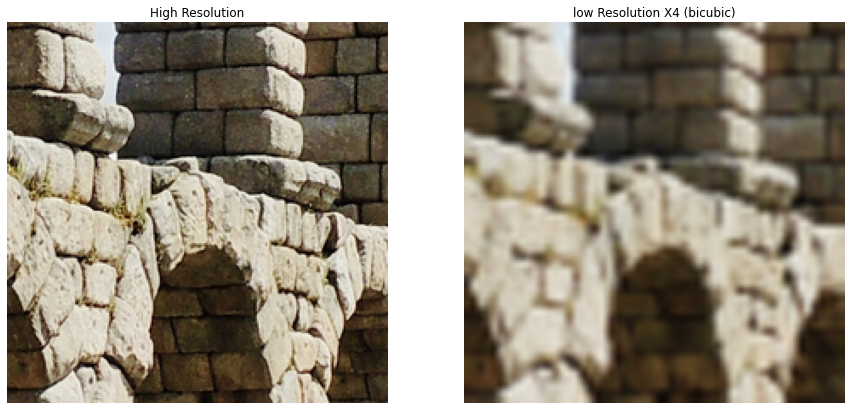

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(256,256),interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [ ]:
#Creating the model
class SRGAN():
  
    def __init__(self,lr_height = 56,lr_width = 56,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = np.array(high_reso_imgs).shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,self.samples-1,batch_size)
            
            indx_low = np.random.randint(0,self.samples-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = (np.array(high_reso_imgs)[indx_high]/127.5)-1
            norm_lr = (np.array(low_reso_imgs)[indx_low]/127.5) -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,self.samples-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = (np.array(high_reso_imgs)[indx]/127.5)-1
        norm_lr = (np.array(low_reso_imgs)[indx]/127.5) -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):

        vgg = VGG19(weights = "imagenet")
  
        model = Model(inputs=vgg.inputs, outputs=[vgg.layers[9].output])

        model.trainable = False
        
        model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),metrics =['acc'])
        return model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)

        self.discriminator.trainable = False

        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], outputs = [generator_valid, generated_features])
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])


In [ ]:
model_srgan = SRGAN()

574717952/574710816 [==============================] - 5s 0us/step
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 224, 224, 3)  8979715     input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 14, 14, 1)    3759681     functional_5[0][0]               
____________________

In [ ]:
model_srgan.generator.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 56, 56, 64)   15616       input_3[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 56, 56, 64)   200704      conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 56, 56, 64)   36928       p_re_lu[0][0]                    
_______________________________________________________________________________________

In [ ]:
model_srgan.discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)    

In [ ]:
os.chdir('/content/drive/MyDrive/DS203_Project/')
!mkdir training_process
os.chdir('./training_process')

**Training for 400 epochs and saving the model after every 20**

--------------- Epoch 1 ---------------




 0.8249021768569946 46.99494552612305
--------------- Epoch 2 ---------------




 0.794859766960144 34.50212097167969
--------------- Epoch 3 ---------------




 0.7330504655838013 28.071897506713867
--------------- Epoch 4 ---------------




 0.6832119822502136 23.201547622680664
--------------- Epoch 5 ---------------




 1.5232852697372437 16.748483657836914
--------------- Epoch 6 ---------------




 0.5935403108596802 24.19112205505371
--------------- Epoch 7 ---------------




 1.1439424753189087 17.86545753479004
--------------- Epoch 8 ---------------




 1.5173828601837158 15.848979949951172
--------------- Epoch 9 ---------------




 0.9870599508285522 17.336833953857422
--------------- Epoch 10 ---------------




 1.6031666994094849 16.129411697387695
--------------- Epoch 11 ---------------




 1.7577335834503174 11.56679630279541
--------------- Epoch 12 ---------------




 1.6188952922821045 16.1649112701416
--------------- Epoch 13 ---------------




 1.2614469528198242 11.598570823669434
--------------- Epoch 14 ---------------




 1.3147469758987427 14.549708366394043
--------------- Epoch 15 ---------------




 1.3488216400146484 14.498250007629395
--------------- Epoch 16 ---------------




 1.5238996744155884 10.671892166137695
--------------- Epoch 17 ---------------




 1.4175455570220947 14.294413566589355
--------------- Epoch 18 ---------------




 1.2643357515335083 9.373113632202148
--------------- Epoch 19 ---------------




 1.6777637004852295 7.901556968688965
--------------- Epoch 20 ---------------


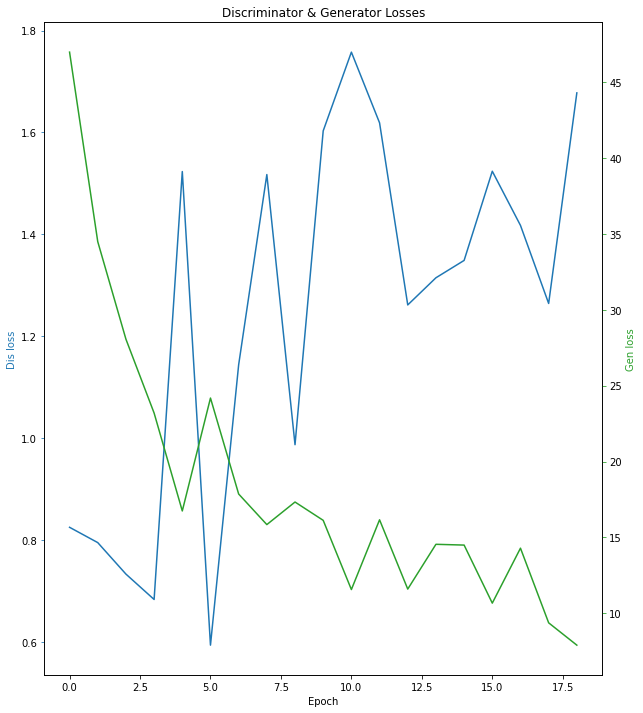


 1.6982766389846802 14.128196716308594
--------------- Epoch 21 ---------------




 1.607442855834961 11.119369506835938
--------------- Epoch 22 ---------------




 1.445400357246399 10.565390586853027
--------------- Epoch 23 ---------------




 1.7382813692092896 10.079167366027832
--------------- Epoch 24 ---------------




 1.5494409799575806 10.080384254455566
--------------- Epoch 25 ---------------




 1.8765578269958496 9.284048080444336
--------------- Epoch 26 ---------------




 1.5966368913650513 13.448140144348145
--------------- Epoch 27 ---------------




 1.6210031509399414 10.082864761352539
--------------- Epoch 28 ---------------




 1.681165099143982 11.632543563842773
--------------- Epoch 29 ---------------




 1.548635721206665 10.348030090332031
--------------- Epoch 30 ---------------




 1.7675414085388184 7.476694583892822
--------------- Epoch 31 ---------------




 1.6207911968231201 10.103694915771484
--------------- Epoch 32 ---------------




 2.005807638168335 9.721641540527344
--------------- Epoch 33 ---------------




 1.7283294200897217 9.466131210327148
--------------- Epoch 34 ---------------




 1.7117422819137573 8.16201400756836
--------------- Epoch 35 ---------------




 1.7890640497207642 7.3688764572143555
--------------- Epoch 36 ---------------




 1.9062225818634033 10.601641654968262
--------------- Epoch 37 ---------------




 1.8331547975540161 9.912881851196289
--------------- Epoch 38 ---------------




 1.966224193572998 9.872673034667969
--------------- Epoch 39 ---------------




 1.6379166841506958 9.587839126586914
--------------- Epoch 40 ---------------


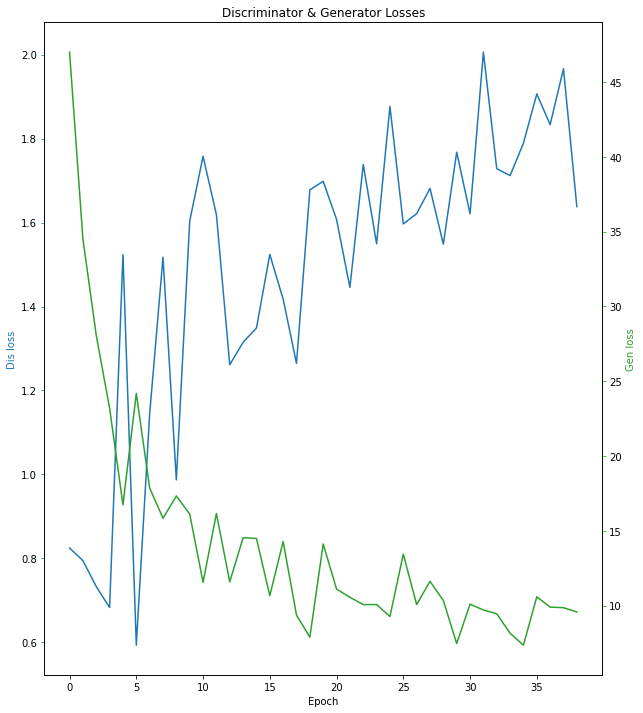


 2.1404242515563965 8.14626693725586
--------------- Epoch 41 ---------------




 1.8431695699691772 8.635018348693848
--------------- Epoch 42 ---------------




 2.36924147605896 7.4569196701049805
--------------- Epoch 43 ---------------




 1.8806326389312744 7.159092426300049
--------------- Epoch 44 ---------------




 2.344953775405884 8.520187377929688
--------------- Epoch 45 ---------------




 2.128587007522583 9.531691551208496
--------------- Epoch 46 ---------------




 2.0232789516448975 6.404821395874023
--------------- Epoch 47 ---------------




 1.9239704608917236 6.468606472015381
--------------- Epoch 48 ---------------




 2.160107374191284 9.010831832885742
--------------- Epoch 49 ---------------




 2.075516700744629 6.301563262939453
--------------- Epoch 50 ---------------




 2.1461620330810547 7.455905437469482
--------------- Epoch 51 ---------------




 1.9499471187591553 7.840203762054443
--------------- Epoch 52 ---------------




 1.987235188484192 5.833270072937012
--------------- Epoch 53 ---------------




 1.9915047883987427 6.8806939125061035
--------------- Epoch 54 ---------------




 2.400933027267456 5.6530256271362305
--------------- Epoch 55 ---------------




 2.188300848007202 7.26962947845459
--------------- Epoch 56 ---------------




 2.0921688079833984 6.56084680557251
--------------- Epoch 57 ---------------




 2.2033917903900146 5.576659679412842
--------------- Epoch 58 ---------------




 2.1505110263824463 6.433721542358398
--------------- Epoch 59 ---------------




 1.8787888288497925 6.413756370544434
--------------- Epoch 60 ---------------


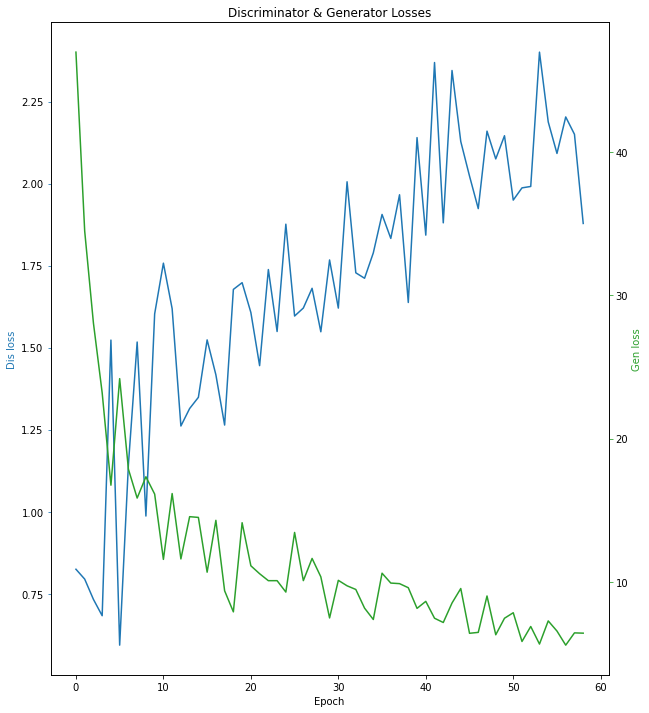


 2.156069040298462 6.615721225738525
--------------- Epoch 61 ---------------




 2.3068783283233643 6.620423316955566
--------------- Epoch 62 ---------------




 2.221123456954956 5.65244197845459
--------------- Epoch 63 ---------------




 2.496171236038208 7.2621235847473145
--------------- Epoch 64 ---------------




 2.505082368850708 5.911591053009033
--------------- Epoch 65 ---------------




 2.1541004180908203 4.5294575691223145
--------------- Epoch 66 ---------------




 2.061800003051758 5.489184856414795
--------------- Epoch 67 ---------------




 2.4084768295288086 3.9342708587646484
--------------- Epoch 68 ---------------




 1.8722076416015625 5.551637649536133
--------------- Epoch 69 ---------------




 2.0827877521514893 5.135737895965576
--------------- Epoch 70 ---------------




 2.4535584449768066 5.484191417694092
--------------- Epoch 71 ---------------




 2.460524797439575 5.687387943267822
--------------- Epoch 72 ---------------




 2.481414556503296 4.998138427734375
--------------- Epoch 73 ---------------




 2.3318538665771484 5.260024547576904
--------------- Epoch 74 ---------------




 2.401249885559082 8.523079872131348
--------------- Epoch 75 ---------------




 2.4629502296447754 6.009719371795654
--------------- Epoch 76 ---------------




 2.3250062465667725 4.911167621612549
--------------- Epoch 77 ---------------




 2.560116767883301 5.379892826080322
--------------- Epoch 78 ---------------




 2.505847454071045 5.052916526794434
--------------- Epoch 79 ---------------




 2.347109794616699 4.481914520263672
--------------- Epoch 80 ---------------


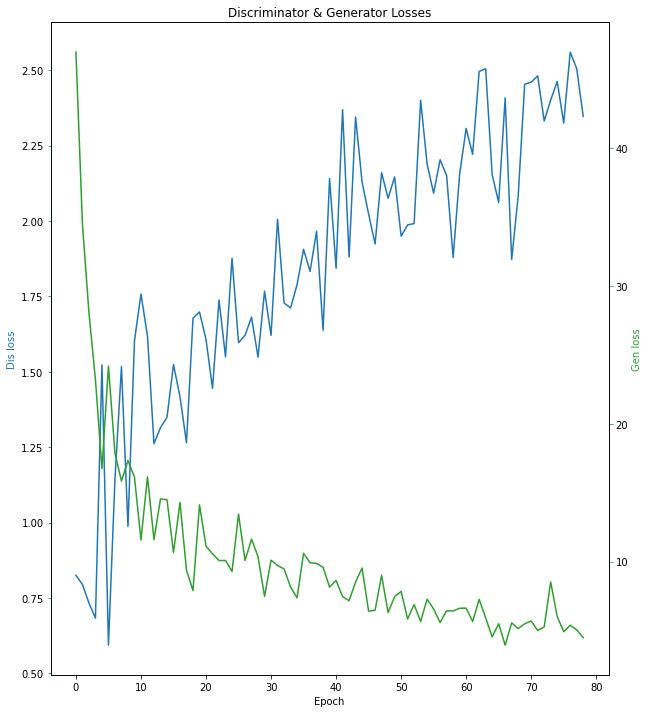


 2.4535207748413086 4.747457504272461
--------------- Epoch 81 ---------------




 2.2793591022491455 3.6760592460632324
--------------- Epoch 82 ---------------




 2.327375650405884 4.457945823669434
--------------- Epoch 83 ---------------




 2.2695045471191406 4.065208435058594
--------------- Epoch 84 ---------------




 2.5815885066986084 4.6598405838012695
--------------- Epoch 85 ---------------




 2.401545524597168 3.778453826904297
--------------- Epoch 86 ---------------




 2.5464673042297363 4.057703495025635
--------------- Epoch 87 ---------------




 2.6202802658081055 4.266349792480469
--------------- Epoch 88 ---------------




 2.5537848472595215 4.249685764312744
--------------- Epoch 89 ---------------




 2.6470115184783936 4.984161376953125
--------------- Epoch 90 ---------------




 2.312779188156128 4.337574481964111
--------------- Epoch 91 ---------------




 2.6104300022125244 4.287222862243652
--------------- Epoch 92 ---------------




 2.5832951068878174 3.8592803478240967
--------------- Epoch 93 ---------------




 2.4696671962738037 4.2933173179626465
--------------- Epoch 94 ---------------




 2.655129909515381 5.085386753082275
--------------- Epoch 95 ---------------




 2.5776188373565674 3.3606839179992676
--------------- Epoch 96 ---------------




 2.7347068786621094 3.7790584564208984
--------------- Epoch 97 ---------------




 2.546518087387085 3.507554292678833
--------------- Epoch 98 ---------------




 2.4131243228912354 4.137736797332764
--------------- Epoch 99 ---------------




 2.3893802165985107 4.190379619598389
--------------- Epoch 100 ---------------


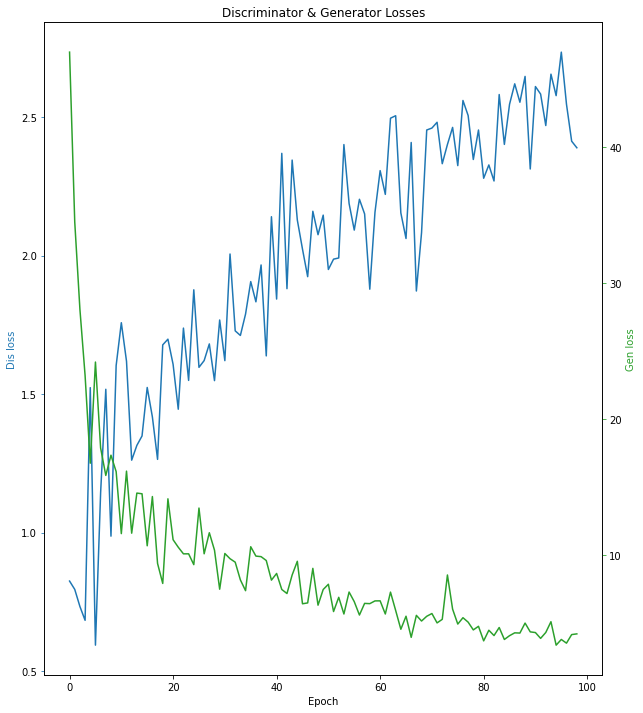


 2.774620294570923 3.941514015197754
--------------- Epoch 101 ---------------




 2.7924811840057373 3.429082155227661
--------------- Epoch 102 ---------------




 2.6538736820220947 3.8756113052368164
--------------- Epoch 103 ---------------




 2.617501735687256 3.4360084533691406
--------------- Epoch 104 ---------------




 2.540318727493286 3.5937421321868896
--------------- Epoch 105 ---------------




 2.635089159011841 2.9264392852783203
--------------- Epoch 106 ---------------




 2.621168851852417 4.541378498077393
--------------- Epoch 107 ---------------




 2.859466552734375 3.816192388534546
--------------- Epoch 108 ---------------




 2.4085609912872314 3.3115286827087402
--------------- Epoch 109 ---------------




 2.672142267227173 3.9026806354522705
--------------- Epoch 110 ---------------




 2.4712886810302734 4.06594181060791
--------------- Epoch 111 ---------------




 2.416118621826172 3.3735616207122803
--------------- Epoch 112 ---------------




 2.4171102046966553 4.1597442626953125
--------------- Epoch 113 ---------------




 2.777723550796509 3.291231155395508
--------------- Epoch 114 ---------------




 2.7571237087249756 3.744694471359253
--------------- Epoch 115 ---------------




 2.7076969146728516 4.193044662475586
--------------- Epoch 116 ---------------




 2.5628247261047363 3.8876540660858154
--------------- Epoch 117 ---------------




 2.872074604034424 3.565606117248535
--------------- Epoch 118 ---------------




 2.8509554862976074 3.7338387966156006
--------------- Epoch 119 ---------------




 2.6143674850463867 3.3287360668182373
--------------- Epoch 120 ---------------


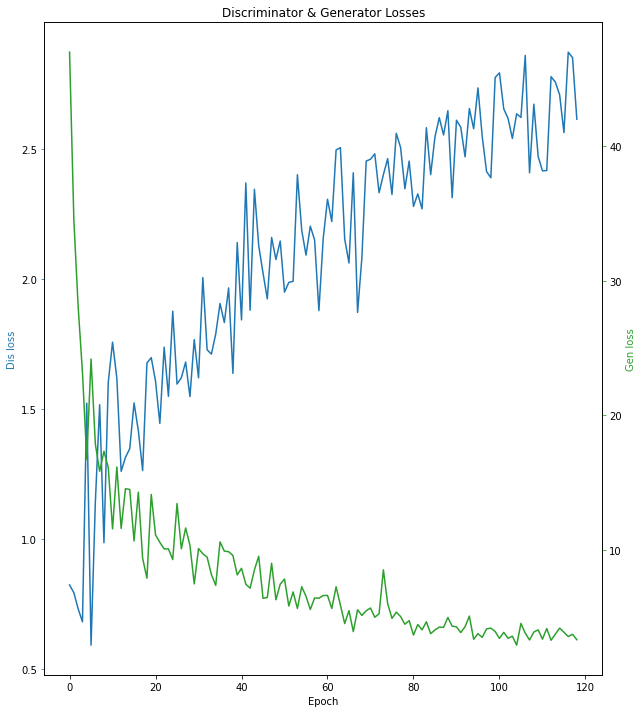


 2.6713836193084717 2.796496629714966
--------------- Epoch 121 ---------------




 2.8152031898498535 3.572786808013916
--------------- Epoch 122 ---------------




 2.582670211791992 3.286287307739258
--------------- Epoch 123 ---------------




 2.7800967693328857 2.844204902648926
--------------- Epoch 124 ---------------




 2.7297096252441406 2.735158681869507
--------------- Epoch 125 ---------------




 2.8347420692443848 3.6105432510375977
--------------- Epoch 126 ---------------




 3.181309223175049 2.5931687355041504
--------------- Epoch 127 ---------------




 2.8389699459075928 3.6287436485290527
--------------- Epoch 128 ---------------




 2.8200299739837646 3.509925127029419
--------------- Epoch 129 ---------------




 3.135680913925171 2.842153549194336
--------------- Epoch 130 ---------------




 2.9460387229919434 2.7564992904663086
--------------- Epoch 131 ---------------




 3.1366095542907715 3.3811697959899902
--------------- Epoch 132 ---------------




 3.017463207244873 2.893763542175293
--------------- Epoch 133 ---------------




 2.629643678665161 2.7175347805023193
--------------- Epoch 134 ---------------




 2.821384906768799 3.4236607551574707
--------------- Epoch 135 ---------------




 2.8746142387390137 3.3181145191192627
--------------- Epoch 136 ---------------




 2.9274702072143555 3.1376683712005615
--------------- Epoch 137 ---------------




 2.9930479526519775 3.3268496990203857
--------------- Epoch 138 ---------------




 3.017118215560913 3.4042482376098633
--------------- Epoch 139 ---------------




 2.9840893745422363 3.155526876449585
--------------- Epoch 140 ---------------


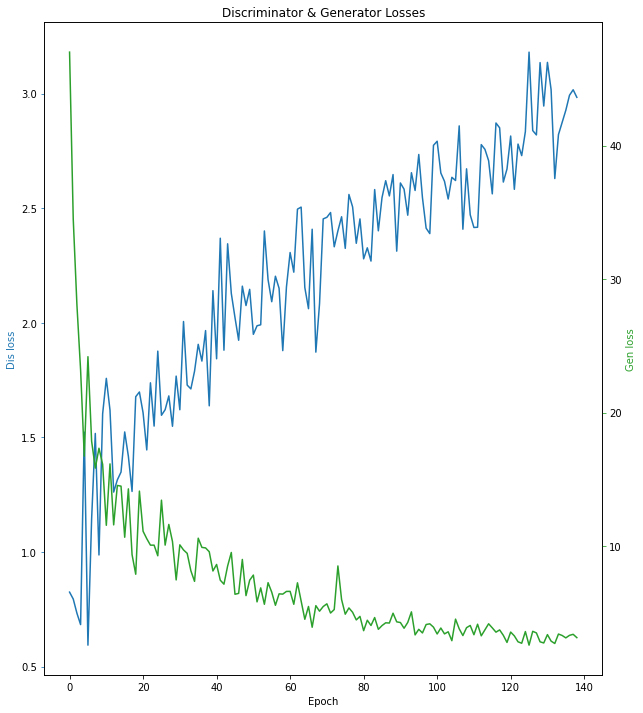


 3.0534486770629883 3.114365339279175
--------------- Epoch 141 ---------------




 3.271873712539673 3.7927772998809814
--------------- Epoch 142 ---------------




 2.850635051727295 3.160656213760376
--------------- Epoch 143 ---------------




 2.9767184257507324 2.9299585819244385
--------------- Epoch 144 ---------------




 2.992946147918701 2.6548354625701904
--------------- Epoch 145 ---------------




 3.4051363468170166 3.014822483062744
--------------- Epoch 146 ---------------




 3.2224395275115967 3.212069511413574
--------------- Epoch 147 ---------------




 3.332120895385742 3.6653754711151123
--------------- Epoch 148 ---------------




 3.0772993564605713 2.6187684535980225
--------------- Epoch 149 ---------------




 2.976571559906006 3.282898426055908
--------------- Epoch 150 ---------------




 3.3160157203674316 2.792048931121826
--------------- Epoch 151 ---------------




 3.0834970474243164 2.5848186016082764
--------------- Epoch 152 ---------------




 3.0134050846099854 3.0197222232818604
--------------- Epoch 153 ---------------




 3.180830955505371 2.2557532787323
--------------- Epoch 154 ---------------




 3.345947504043579 3.1092031002044678
--------------- Epoch 155 ---------------




 2.851656913757324 2.8920276165008545
--------------- Epoch 156 ---------------




 3.034633159637451 2.294299364089966
--------------- Epoch 157 ---------------




 2.960862159729004 2.681246519088745
--------------- Epoch 158 ---------------




 3.2978498935699463 3.0368778705596924
--------------- Epoch 159 ---------------




 3.2731800079345703 3.451535701751709
--------------- Epoch 160 ---------------


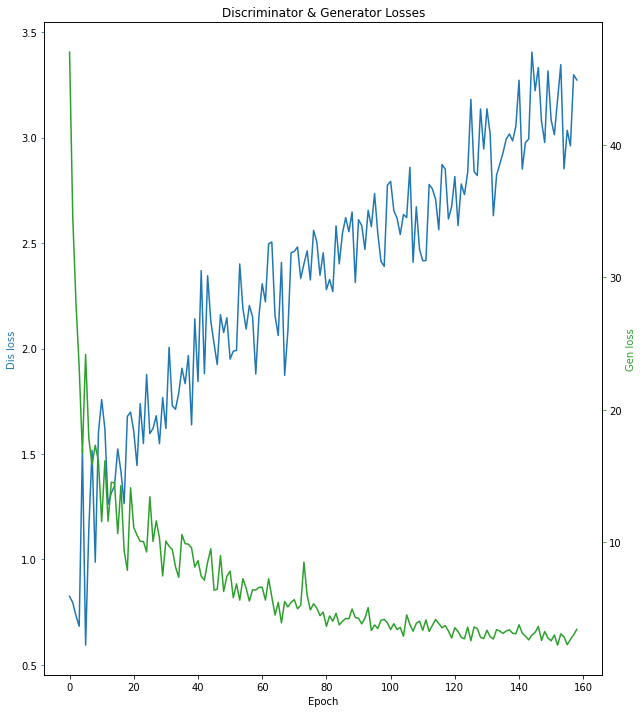


 2.7370212078094482 3.123699188232422
--------------- Epoch 161 ---------------




 3.105388641357422 2.766951560974121
--------------- Epoch 162 ---------------




 3.0961544513702393 2.492689609527588
--------------- Epoch 163 ---------------




 3.5547523498535156 2.4609851837158203
--------------- Epoch 164 ---------------




 2.8923845291137695 2.4275381565093994
--------------- Epoch 165 ---------------




 2.900052547454834 2.5822031497955322
--------------- Epoch 166 ---------------




 3.247370719909668 2.4324729442596436
--------------- Epoch 167 ---------------




 3.019343852996826 2.921464204788208
--------------- Epoch 168 ---------------




 3.1196236610412598 3.019947052001953
--------------- Epoch 169 ---------------




 2.957406997680664 2.0171384811401367
--------------- Epoch 170 ---------------




 3.1715688705444336 2.951416492462158
--------------- Epoch 171 ---------------




 3.288764238357544 2.5952200889587402
--------------- Epoch 172 ---------------




 3.44670033454895 2.833012342453003
--------------- Epoch 173 ---------------




 3.4304287433624268 2.244943380355835
--------------- Epoch 174 ---------------




 3.30247163772583 2.559475898742676
--------------- Epoch 175 ---------------




 3.033414840698242 2.616307020187378
--------------- Epoch 176 ---------------




 3.0145182609558105 2.367600202560425
--------------- Epoch 177 ---------------




 3.18662428855896 2.5975565910339355
--------------- Epoch 178 ---------------




 3.3838014602661133 2.1486687660217285
--------------- Epoch 179 ---------------




 3.473139762878418 2.8395285606384277
--------------- Epoch 180 ---------------


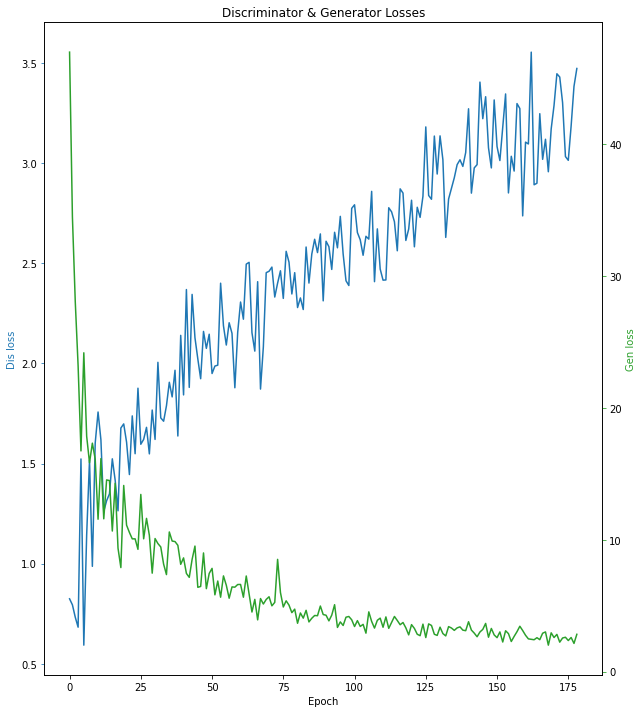


 3.4638304710388184 2.479076623916626
--------------- Epoch 181 ---------------




 3.1753265857696533 2.181300401687622
--------------- Epoch 182 ---------------




 3.5675008296966553 2.1663260459899902
--------------- Epoch 183 ---------------




 3.290229558944702 2.604619264602661
--------------- Epoch 184 ---------------




 3.6225364208221436 2.752455949783325
--------------- Epoch 185 ---------------




 3.1353516578674316 2.3538689613342285
--------------- Epoch 186 ---------------




 3.2085509300231934 2.382617950439453
--------------- Epoch 187 ---------------




 3.159970998764038 2.835728883743286
--------------- Epoch 188 ---------------




 2.637718677520752 2.2540974617004395
--------------- Epoch 189 ---------------




 3.453815460205078 3.861699104309082
--------------- Epoch 190 ---------------




 3.076357126235962 2.509199380874634
--------------- Epoch 191 ---------------




 3.213139057159424 2.2641756534576416
--------------- Epoch 192 ---------------




 3.390871047973633 2.51509690284729
--------------- Epoch 193 ---------------




 3.4635915756225586 2.693424701690674
--------------- Epoch 194 ---------------




 3.3032469749450684 2.8444368839263916
--------------- Epoch 195 ---------------




 3.623326301574707 2.388169765472412
--------------- Epoch 196 ---------------




 3.032538652420044 2.226797580718994
--------------- Epoch 197 ---------------




 3.5353691577911377 2.869724750518799
--------------- Epoch 198 ---------------




 3.205617904663086 2.663677215576172
--------------- Epoch 199 ---------------




 3.509605884552002 1.8922662734985352
--------------- Epoch 200 ---------------


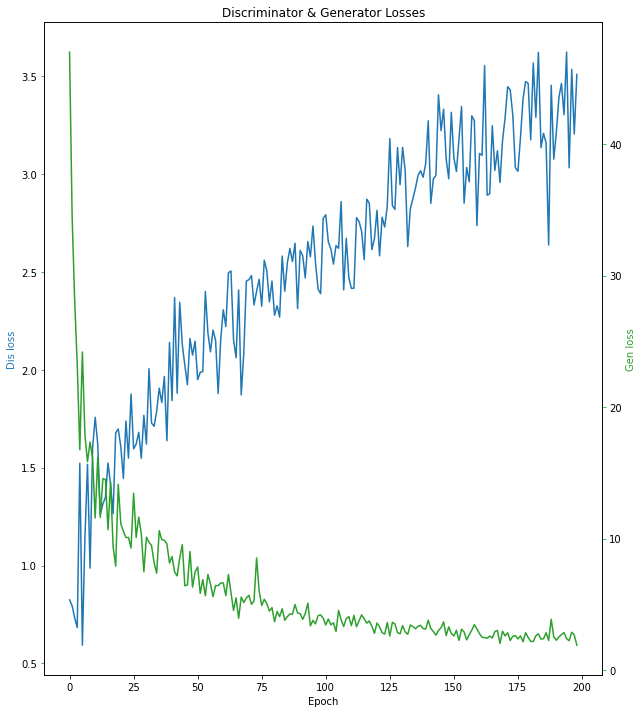


 3.0559897422790527 2.0691137313842773
--------------- Epoch 201 ---------------




 3.4253287315368652 3.111671209335327
--------------- Epoch 202 ---------------




 3.5546224117279053 2.7295682430267334
--------------- Epoch 203 ---------------




 3.356477975845337 2.563408851623535
--------------- Epoch 204 ---------------




 2.7622904777526855 2.157043933868408
--------------- Epoch 205 ---------------




 3.194122314453125 2.452601432800293
--------------- Epoch 206 ---------------




 3.252779960632324 2.117642402648926
--------------- Epoch 207 ---------------




 3.7451701164245605 2.3541696071624756
--------------- Epoch 208 ---------------




 3.267928123474121 1.9382401704788208
--------------- Epoch 209 ---------------




 3.64841628074646 2.2187466621398926
--------------- Epoch 210 ---------------




 3.155531883239746 2.4152989387512207
--------------- Epoch 211 ---------------




 2.8751442432403564 2.0493323802948
--------------- Epoch 212 ---------------




 3.8277387619018555 2.1147522926330566
--------------- Epoch 213 ---------------




 3.4722259044647217 1.9783446788787842
--------------- Epoch 214 ---------------




 3.390903949737549 2.4510276317596436
--------------- Epoch 215 ---------------




 3.6929166316986084 2.2310636043548584
--------------- Epoch 216 ---------------




 3.1826560497283936 2.2411088943481445
--------------- Epoch 217 ---------------




 3.2093636989593506 2.3204054832458496
--------------- Epoch 218 ---------------




 3.064370632171631 2.7282450199127197
--------------- Epoch 219 ---------------




 3.3635354042053223 2.018123149871826
--------------- Epoch 220 ---------------


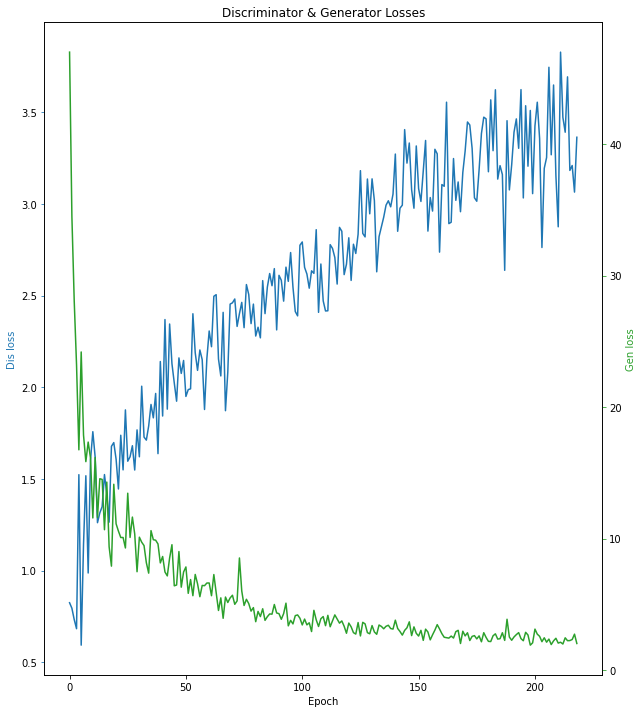


 3.2807865142822266 2.1240954399108887
--------------- Epoch 221 ---------------




 3.5295209884643555 2.602583169937134
--------------- Epoch 222 ---------------




 3.4390501976013184 2.5191476345062256
--------------- Epoch 223 ---------------




 3.140984296798706 2.0691466331481934
--------------- Epoch 224 ---------------




 3.288020610809326 1.8382477760314941
--------------- Epoch 225 ---------------




 3.772468328475952 1.922769546508789
--------------- Epoch 226 ---------------




 3.3682961463928223 2.0049986839294434
--------------- Epoch 227 ---------------




 3.220402240753174 1.8979129791259766
--------------- Epoch 228 ---------------




 3.2517220973968506 2.445145606994629
--------------- Epoch 229 ---------------




 3.7585482597351074 2.013035535812378
--------------- Epoch 230 ---------------




 3.7530272006988525 2.376586437225342
--------------- Epoch 231 ---------------




 3.6796512603759766 2.1949877738952637
--------------- Epoch 232 ---------------




 3.8782544136047363 2.120465040206909
--------------- Epoch 233 ---------------




 3.623095750808716 1.696418046951294
--------------- Epoch 234 ---------------




 3.8185524940490723 2.266213893890381
--------------- Epoch 235 ---------------




 3.2305407524108887 1.7935124635696411
--------------- Epoch 236 ---------------




 3.47312593460083 1.9609795808792114
--------------- Epoch 237 ---------------




 3.3032031059265137 2.2307333946228027
--------------- Epoch 238 ---------------




 3.763709783554077 2.352128505706787
--------------- Epoch 239 ---------------




 3.6957578659057617 2.1209664344787598
--------------- Epoch 240 ---------------


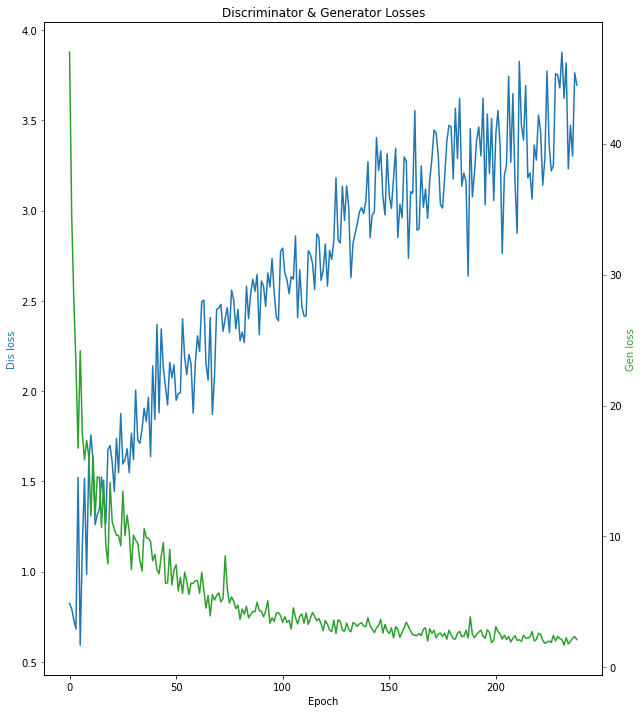


 3.7226879596710205 2.7223875522613525
--------------- Epoch 241 ---------------




 3.5976977348327637 1.995237112045288
--------------- Epoch 242 ---------------




 3.4974935054779053 2.4854531288146973
--------------- Epoch 243 ---------------




 3.649672746658325 1.9026398658752441
--------------- Epoch 244 ---------------




 3.521925926208496 2.094496250152588
--------------- Epoch 245 ---------------




 3.546501636505127 2.057161808013916
--------------- Epoch 246 ---------------




 3.570061206817627 2.0823514461517334
--------------- Epoch 247 ---------------




 3.3721911907196045 2.1464974880218506
--------------- Epoch 248 ---------------




 3.3162708282470703 1.5538153648376465
--------------- Epoch 249 ---------------




 3.5250375270843506 2.839629650115967
--------------- Epoch 250 ---------------




 3.5920400619506836 1.7186660766601562
--------------- Epoch 251 ---------------




 3.7847554683685303 1.8931833505630493
--------------- Epoch 252 ---------------




 3.4146528244018555 2.0118792057037354
--------------- Epoch 253 ---------------




 3.7308621406555176 2.06412672996521
--------------- Epoch 254 ---------------




 3.571655035018921 1.8098342418670654
--------------- Epoch 255 ---------------




 3.5957324504852295 2.2556064128875732
--------------- Epoch 256 ---------------




 3.768585205078125 2.0821001529693604
--------------- Epoch 257 ---------------




 3.6597962379455566 2.0084228515625
--------------- Epoch 258 ---------------




 3.6689414978027344 2.3945469856262207
--------------- Epoch 259 ---------------




 3.793586492538452 2.170135259628296
--------------- Epoch 260 ---------------


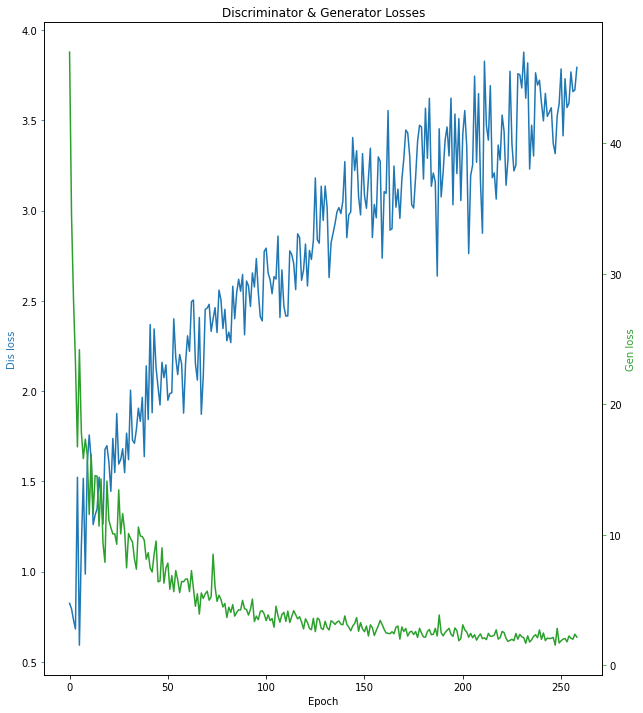


 2.8528800010681152 1.9116016626358032
--------------- Epoch 261 ---------------




 3.9461276531219482 2.292370557785034
--------------- Epoch 262 ---------------




 3.4114949703216553 1.6549636125564575
--------------- Epoch 263 ---------------




 3.920731544494629 1.8652241230010986
--------------- Epoch 264 ---------------




 3.7121407985687256 2.573328733444214
--------------- Epoch 265 ---------------




 3.777618169784546 1.4342859983444214
--------------- Epoch 266 ---------------




 3.6233744621276855 2.0267465114593506
--------------- Epoch 267 ---------------




 3.534817695617676 1.8452637195587158
--------------- Epoch 268 ---------------




 3.8771860599517822 1.9834675788879395
--------------- Epoch 269 ---------------




 3.5735769271850586 1.5714513063430786
--------------- Epoch 270 ---------------




 3.5584428310394287 1.8470057249069214
--------------- Epoch 271 ---------------




 3.695497989654541 1.640855312347412
--------------- Epoch 272 ---------------




 3.847717046737671 2.4188921451568604
--------------- Epoch 273 ---------------




 3.867324113845825 1.941266655921936
--------------- Epoch 274 ---------------




 3.572565793991089 1.610219120979309
--------------- Epoch 275 ---------------




 3.191124200820923 1.9096715450286865
--------------- Epoch 276 ---------------




 3.368147611618042 2.045856237411499
--------------- Epoch 277 ---------------




 3.562838077545166 1.6890714168548584
--------------- Epoch 278 ---------------




 3.6864519119262695 1.938500165939331
--------------- Epoch 279 ---------------




 3.835613965988159 1.6934704780578613
--------------- Epoch 280 ---------------


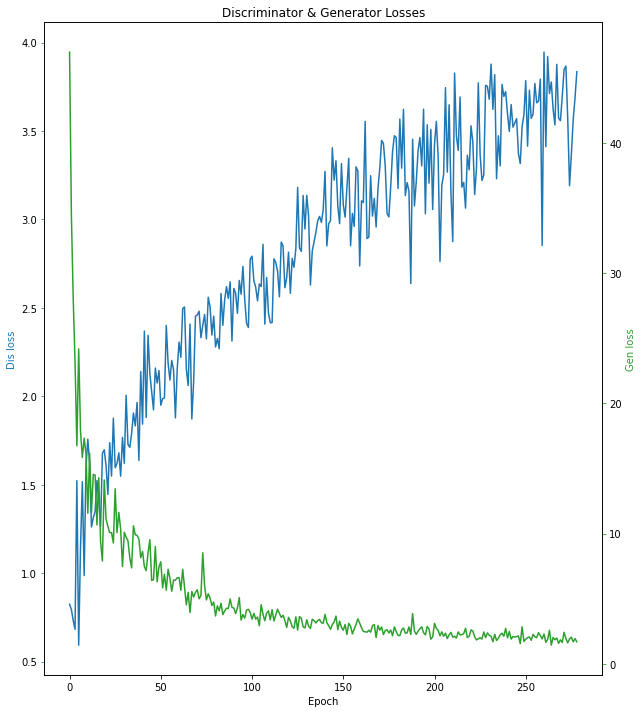


 3.9864675998687744 2.1842293739318848
--------------- Epoch 281 ---------------




 3.8853838443756104 1.964643955230713
--------------- Epoch 282 ---------------




 3.8429806232452393 1.8073303699493408
--------------- Epoch 283 ---------------




 3.617661476135254 1.9238356351852417
--------------- Epoch 284 ---------------




 4.103194236755371 1.8941208124160767
--------------- Epoch 285 ---------------




 3.6843533515930176 1.7986538410186768
--------------- Epoch 286 ---------------




 3.910909652709961 1.8769034147262573
--------------- Epoch 287 ---------------




 3.7346067428588867 2.6447296142578125
--------------- Epoch 288 ---------------




 3.9564526081085205 1.7013754844665527
--------------- Epoch 289 ---------------




 3.897024631500244 2.3926405906677246
--------------- Epoch 290 ---------------




 3.9103455543518066 1.9628874063491821
--------------- Epoch 291 ---------------




 3.4069337844848633 1.9269806146621704
--------------- Epoch 292 ---------------




 4.151805400848389 1.8820525407791138
--------------- Epoch 293 ---------------




 3.7512874603271484 1.7887203693389893
--------------- Epoch 294 ---------------




 3.8469326496124268 1.517459511756897
--------------- Epoch 295 ---------------




 3.919518232345581 1.7181826829910278
--------------- Epoch 296 ---------------




 3.43373703956604 2.0673112869262695
--------------- Epoch 297 ---------------




 3.8112285137176514 1.4567747116088867
--------------- Epoch 298 ---------------




 4.0106520652771 1.7243062257766724
--------------- Epoch 299 ---------------




 3.8869872093200684 2.1340737342834473
--------------- Epoch 300 ---------------


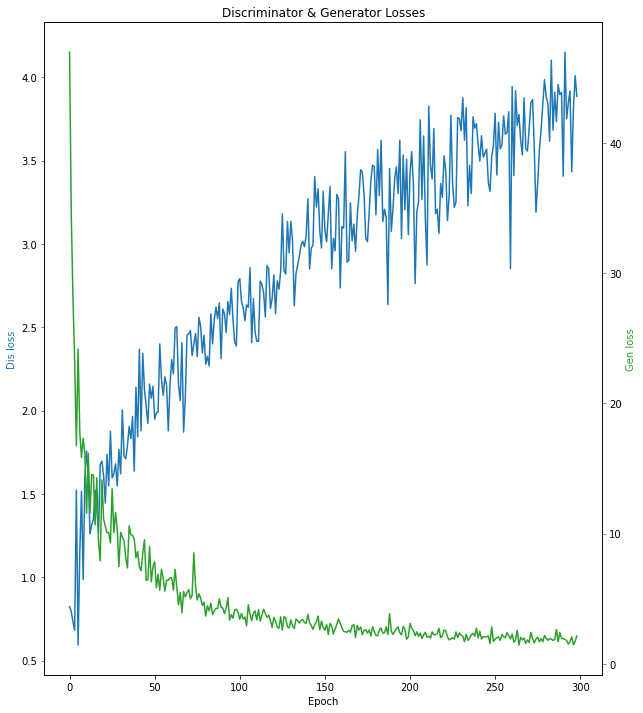


 3.4505181312561035 1.6891770362854004
--------------- Epoch 301 ---------------




 3.838827133178711 2.5909204483032227
--------------- Epoch 302 ---------------




 4.255315780639648 2.043919086456299
--------------- Epoch 303 ---------------




 3.5294551849365234 1.6481271982192993
--------------- Epoch 304 ---------------




 3.809276580810547 1.8100872039794922
--------------- Epoch 305 ---------------




 3.562426805496216 1.6737004518508911
--------------- Epoch 306 ---------------




 3.650825262069702 1.6772650480270386
--------------- Epoch 307 ---------------




 3.8098928928375244 1.7326250076293945
--------------- Epoch 308 ---------------




 3.822512149810791 1.531275749206543
--------------- Epoch 309 ---------------




 3.9067325592041016 1.66995108127594
--------------- Epoch 310 ---------------




 3.8011465072631836 1.481230616569519
--------------- Epoch 311 ---------------




 3.6670427322387695 1.3928136825561523
--------------- Epoch 312 ---------------




 4.095827579498291 1.7566990852355957
--------------- Epoch 313 ---------------




 4.387161731719971 2.2668650150299072
--------------- Epoch 314 ---------------




 3.651413679122925 1.6567530632019043
--------------- Epoch 315 ---------------




 3.7561521530151367 2.08656644821167
--------------- Epoch 316 ---------------




 4.06701135635376 1.7539578676223755
--------------- Epoch 317 ---------------




 3.439474105834961 1.9302961826324463
--------------- Epoch 318 ---------------




 3.704846143722534 1.5230629444122314
--------------- Epoch 319 ---------------




 3.85233473777771 1.666754126548767
--------------- Epoch 320 ---------------


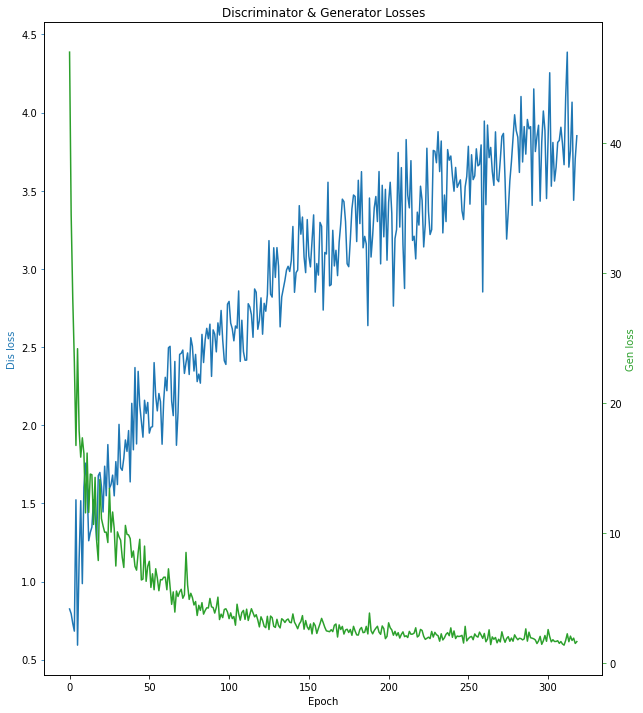


 3.5824434757232666 1.5090593099594116
--------------- Epoch 321 ---------------




 3.8991475105285645 1.6041947603225708
--------------- Epoch 322 ---------------




 4.156974792480469 1.4828249216079712
--------------- Epoch 323 ---------------




 3.834149122238159 1.904107928276062
--------------- Epoch 324 ---------------




 3.5479896068573 1.4803504943847656
--------------- Epoch 325 ---------------




 3.882230758666992 1.9715757369995117
--------------- Epoch 326 ---------------




 4.022221088409424 1.6037626266479492
--------------- Epoch 327 ---------------




 3.920499801635742 1.9765751361846924
--------------- Epoch 328 ---------------




 3.883967399597168 1.47132408618927
--------------- Epoch 329 ---------------




 3.173215627670288 1.7515219449996948
--------------- Epoch 330 ---------------




 3.4156742095947266 1.6191160678863525
--------------- Epoch 331 ---------------




 4.027011871337891 1.6406220197677612
--------------- Epoch 332 ---------------




 3.5730156898498535 1.853898286819458
--------------- Epoch 333 ---------------




 3.6368584632873535 1.7491151094436646
--------------- Epoch 334 ---------------




 3.7302541732788086 1.5745471715927124
--------------- Epoch 335 ---------------




 3.6406521797180176 1.857779622077942
--------------- Epoch 336 ---------------




 3.530827045440674 1.9182708263397217
--------------- Epoch 337 ---------------




 3.3543829917907715 1.629882574081421
--------------- Epoch 338 ---------------




 3.908848285675049 1.5741726160049438
--------------- Epoch 339 ---------------




 3.698660135269165 1.5753813982009888
--------------- Epoch 340 ---------------


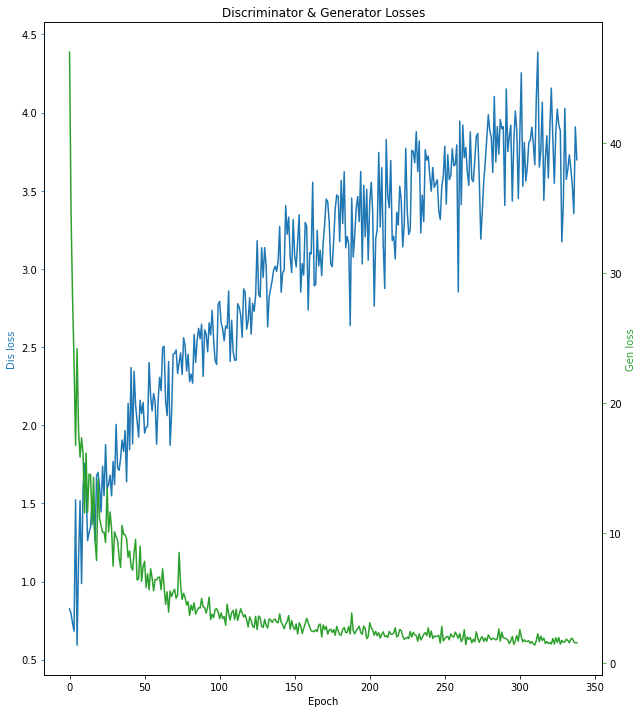


 3.692673683166504 1.4069788455963135
--------------- Epoch 341 ---------------




 3.8424978256225586 2.359806537628174
--------------- Epoch 342 ---------------




 3.5772125720977783 1.4157501459121704
--------------- Epoch 343 ---------------




 3.961117744445801 1.3946142196655273
--------------- Epoch 344 ---------------




 3.678575277328491 1.524461030960083
--------------- Epoch 345 ---------------




 4.124414443969727 1.4059019088745117
--------------- Epoch 346 ---------------




 3.740363359451294 1.4597852230072021
--------------- Epoch 347 ---------------




 3.67232084274292 1.579964518547058
--------------- Epoch 348 ---------------




 3.454014301300049 1.9675148725509644
--------------- Epoch 349 ---------------




 3.5423052310943604 1.640210747718811
--------------- Epoch 350 ---------------




 4.1350998878479 1.7041906118392944
--------------- Epoch 351 ---------------




 3.774568557739258 1.6178255081176758
--------------- Epoch 352 ---------------




 4.102783679962158 1.5817421674728394
--------------- Epoch 353 ---------------




 3.9028754234313965 1.4553953409194946
--------------- Epoch 354 ---------------




 3.8286638259887695 1.5478631258010864
--------------- Epoch 355 ---------------




 4.064330101013184 1.6268274784088135
--------------- Epoch 356 ---------------




 3.6512961387634277 1.5552290678024292
--------------- Epoch 357 ---------------




 3.7366111278533936 1.5325671434402466
--------------- Epoch 358 ---------------




 3.982037305831909 1.5654075145721436
--------------- Epoch 359 ---------------




 3.9405314922332764 1.6361980438232422
--------------- Epoch 360 ---------------


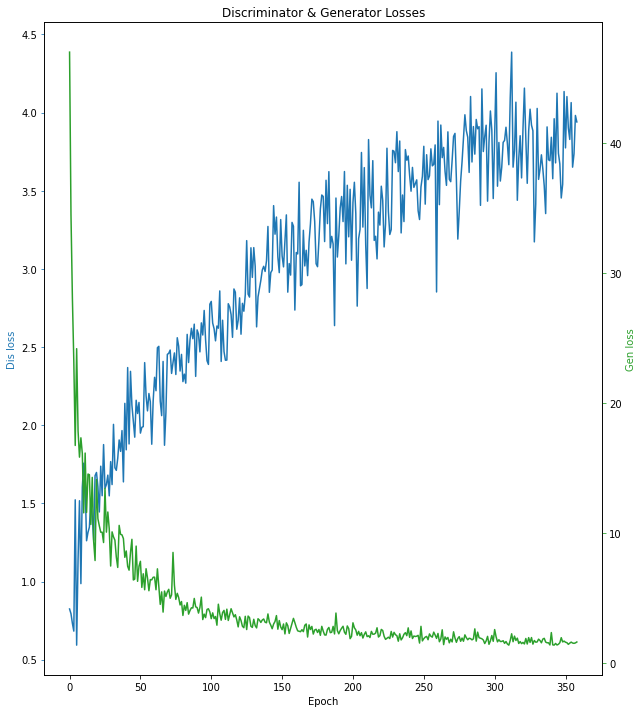


 4.1389946937561035 2.118570566177368
--------------- Epoch 361 ---------------




 3.9887592792510986 1.4275447130203247
--------------- Epoch 362 ---------------




 4.3570380210876465 1.4910284280776978
--------------- Epoch 363 ---------------




 3.8327796459198 1.327052116394043
--------------- Epoch 364 ---------------




 4.24862003326416 1.731804609298706
--------------- Epoch 365 ---------------




 3.4914448261260986 1.3517221212387085
--------------- Epoch 366 ---------------




 3.763460159301758 1.5108654499053955
--------------- Epoch 367 ---------------




 3.6631152629852295 1.5951372385025024
--------------- Epoch 368 ---------------




 4.321675777435303 1.7667179107666016
--------------- Epoch 369 ---------------




 4.286502361297607 1.9421571493148804
--------------- Epoch 370 ---------------




 3.99662446975708 1.5943958759307861
--------------- Epoch 371 ---------------




 3.461674690246582 1.6315690279006958
--------------- Epoch 372 ---------------




 3.6823315620422363 2.1363673210144043
--------------- Epoch 373 ---------------




 3.72935152053833 1.4908534288406372
--------------- Epoch 374 ---------------




 3.711808204650879 1.3637527227401733
--------------- Epoch 375 ---------------




 3.2847695350646973 1.5096691846847534
--------------- Epoch 376 ---------------




 3.76419997215271 1.3240888118743896
--------------- Epoch 377 ---------------




 3.6550421714782715 1.4407151937484741
--------------- Epoch 378 ---------------




 3.775648832321167 1.7261332273483276
--------------- Epoch 379 ---------------




 3.735102653503418 1.3418805599212646
--------------- Epoch 380 ---------------


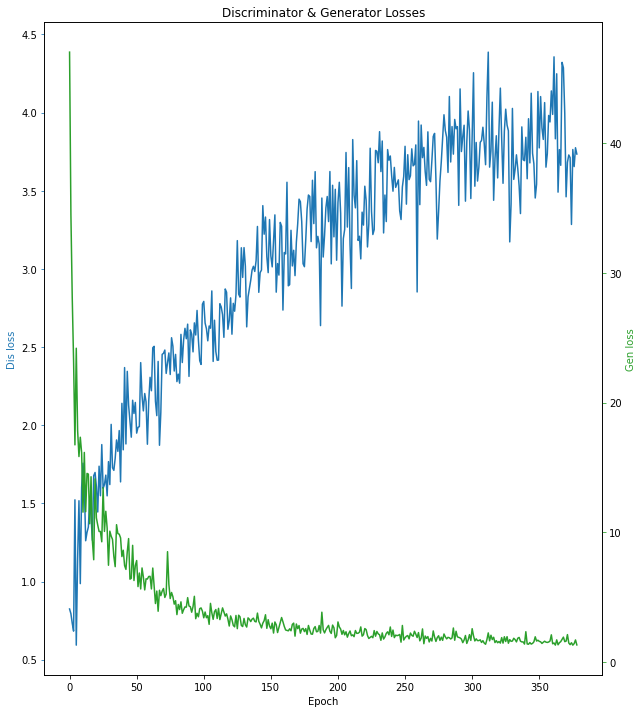


 3.5834922790527344 1.3227155208587646
--------------- Epoch 381 ---------------




 4.367250919342041 1.8222236633300781
--------------- Epoch 382 ---------------




 4.121011734008789 1.3892641067504883
--------------- Epoch 383 ---------------




 3.4453611373901367 1.7618061304092407
--------------- Epoch 384 ---------------




 3.982649803161621 1.6766093969345093
--------------- Epoch 385 ---------------




 4.206099510192871 1.4611930847167969
--------------- Epoch 386 ---------------




 3.725276470184326 1.6783539056777954
--------------- Epoch 387 ---------------




 4.191490173339844 1.3849281072616577
--------------- Epoch 388 ---------------




 3.0490500926971436 1.4312647581100464
--------------- Epoch 389 ---------------




 4.222939491271973 1.5479285717010498
--------------- Epoch 390 ---------------




 3.6000816822052 1.497865915298462
--------------- Epoch 391 ---------------




 3.9155867099761963 1.4232637882232666
--------------- Epoch 392 ---------------




 3.8560733795166016 1.4138211011886597
--------------- Epoch 393 ---------------




 3.53603196144104 1.6928235292434692
--------------- Epoch 394 ---------------




 4.101685047149658 1.538037657737732
--------------- Epoch 395 ---------------




 4.001314640045166 1.6607553958892822
--------------- Epoch 396 ---------------




 3.6901543140411377 1.4585570096969604
--------------- Epoch 397 ---------------




 3.701575517654419 1.4907536506652832
--------------- Epoch 398 ---------------




 4.150594234466553 1.4110932350158691
--------------- Epoch 399 ---------------




 4.177513122558594 1.4945796728134155
--------------- Epoch 400 ---------------


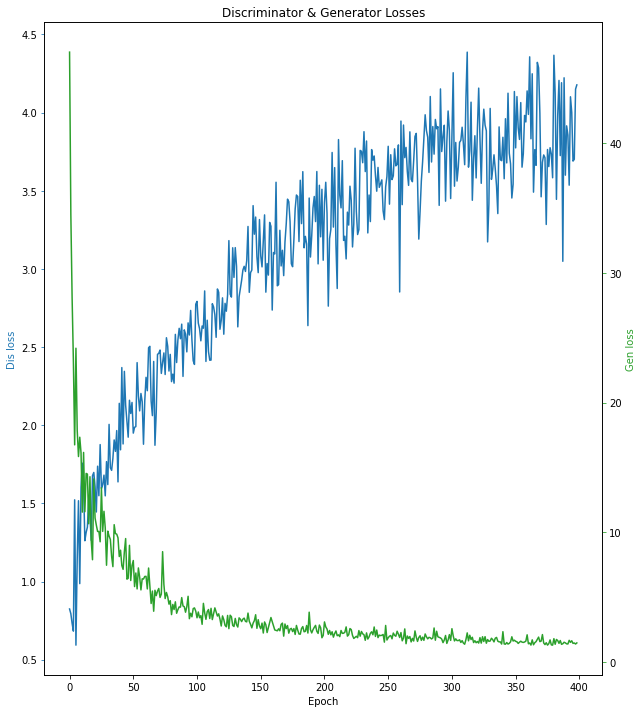


 3.922544002532959 1.287081003189087


In [ ]:
model_srgan.train(400, save_interval=20 ,batch_size=16)

In [ ]:
#Load weights
model_srgan.srgan.load_weights('srgan_weights_epoch_400.h5')

In [ ]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 8):
    plt.figure(figsize = (15,50))
    plt.subplots_adjust(wspace=0.008, hspace=0.005)
    # plt.tight_layout()
    k=0
    for i in range(0,n_imgs*3,3):
        # idx = np.random.randint(0,np.array(low_reso_imgs).shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[k].astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
    
        
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[k],(256,256),interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
  
        valid_im = np.expand_dims(low_reso_imgs[k], axis = 0)
        valid_im = (valid_im/127.5)-1
        img = srgan_model.generator.predict(valid_im)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)

        final = (np.squeeze(img_unnorm, axis = 0)).astype(np.uint8)
        print(np.array(final))
        plt.imshow(final)
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        k = k+1
        
    plt.savefig('predicted.png')
        

In [ ]:
cd '/content/drive/MyDrive/DS203_Project/test1'

/content/drive/.shortcut-targets-by-id/1aLa26ZvFo_AeEOzMRlMOfDKBUCVBbGgF/DS203_Project/test1


**Testing on the test set**

In [ ]:

img_list_test, img_low_list_test = [], []
for i in os.listdir():
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,224,224)
    img_list_test.append(img_crop)
    img_low_list_test.append(img_as_ubyte(resize(img_crop,(56,56))))


high_reso_imgs_test = img_list_test
low_reso_imgs_test = img_low_list_test   

plot_predict(low_reso_imgs_test,high_reso_imgs_test,model_srgan)

Output hidden; open in https://colab.research.google.com to view.